In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.metrics import F1Score, Recall, Precision
from keras.callbacks import EarlyStopping

2024-08-12 10:52:51.985558: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 10:52:51.986395: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 10:52:51.989589: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 10:52:51.997747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 10:52:52.010931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
# loading the dataset
df = pd.read_csv("balanced_new.csv")
df.head()

,title,content,source,label,full_text
0,Pitso Burst Into Fight With His Player Agent O...,It?s not a secret that Sibusiso Vilakazi is c...,hinnews.com,0,pitso burst fight player agent players decisio...
1,Pretoria police caught in human trafficking an...,"According to report, Some criminals may have ...",hinnews.com,0,pretoria police catch human traffic kidnap acc...
2,Kaizer Chiefs Players Reveals Why Chiefs Playe...,Ex-Kaizer Chiefs hardman Tinashe Nengomasha h...,hinnews.com,0,kaizer chiefs players reveal chiefs players su...
3,Malema and Ndlozi to be prosecuted for assault...,Lobby group AfriForum announced in a statemen...,hinnews.com,0,malema ndlozi prosecute assault police officer...
4,Woman survives after being shot 11 times by he...,A Detroit woman is lucky to be alive after sh...,hinnews.com,0,woman survive shoot 11 time wife detroit woman...


#### Getting the descriptive stats of sentence length size 

In [3]:
full_text_length = df["full_text"].apply(lambda x: len(x.split()))     # split it into indivdual words, then check

max_length = full_text_length.max()

In [4]:
# Getting the X and y varibales
X = df["full_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

#### Text preprocessing for deep learning 

converting words in tokens

In [5]:
token = Tokenizer(num_words=max_length, oov_token="<OOV>")

In [6]:
token.fit_on_texts(X_train)
word_index = token.word_index
training_seq = token.texts_to_sequences(X_train)
train_padded = pad_sequences(training_seq,  maxlen=max_length)

#### Splitting the dataset

In [7]:
# train and test split
#80/20 split
X_train, X_valid, y_train, y_valid = train_test_split(train_padded, y_train, test_size=0.5, random_state=42)

X_train

array([[  0,   0,   0, ...,   1,   1,   1],
       [  0,   0,   0, ..., 201, 386,   1],
       [  0,   0,   0, ..., 144, 659, 365],
       ...,
       [  0,   0,   0, ..., 390,   1,   1],
       [  0,   0,   0, ..., 571,  17,   1],
       [  0,   0,   0, ..., 972,   9, 286]], dtype=int32)

### Building the model

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(10000, 128))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64,return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
model.add(keras.layers.Dense(128,activation="relu",  kernel_regularizer=l2(0.01)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [9]:
f1 = F1Score(threshold=0.5)

callbacks = [
        EarlyStopping(monitor='val_precision', verbose=1,  mode="max")
    ]

model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=["accuracy", f1, Recall, Precision])

In [10]:
history = model.fit(X_train, y_train,  batch_size=32,  epochs=5,  validation_data=(X_valid,y_valid), callbacks=callbacks)

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 947ms/step - accuracy: 0.4243 - f1_score: 0.5136 - loss: 1.9032 - precision: 0.4606 - recall: 0.5930 - val_accuracy: 0.5312 - val_f1_score: 0.6939 - val_loss: 1.6804 - val_precision: 0.5312 - val_recall: 1.0000
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 916ms/step - accuracy: 0.5603 - f1_score: 0.7164 - loss: 1.6083 - precision: 0.5676 - recall: 0.9761 - val_accuracy: 0.5793 - val_f1_score: 0.7145 - val_loss: 1.4313 - val_precision: 0.5587 - val_recall: 0.9910
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 914ms/step - accuracy: 0.7268 - f1_score: 0.7764 - loss: 1.3376 - precision: 0.6773 - recall: 0.9146 - val_accuracy: 0.7885 - val_f1_score: 0.8079 - val_loss: 1.1039 - val_precision: 0.7806 - val_recall: 0.8371
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 929ms/step - accuracy: 0.8967 - f1_score: 0.9089 - loss: 0.8914 - precision: 0.8890 - recall: 0.9307 - val_accuracy: 0.7861 - val_f1_score: 0.8279 - val_loss: 1.2873 - val_precision: 0.7230 - val_recall:

In [11]:
history.history

{'accuracy': [0.45542168617248535,
  0.5349397659301758,
  0.7469879388809204,
  0.9132530093193054],
 'f1_score': [0.5670497417449951,
  0.6911999583244324,
  0.7817047238349915,
  0.9181817770004272],
 'loss': [1.8393173217773438,
  1.5585100650787354,
  1.2661329507827759,
  0.8103451132774353],
 'precision': [0.4868420958518982,
  0.5307125449180603,
  0.7148289084434509,
  0.9099099040031433],
 'recall': [0.6788991093635559,
  0.9908257126808167,
  0.8623853325843811,
  0.9266055226325989],
 'val_accuracy': [0.53125,
  0.5793269276618958,
  0.7884615659713745,
  0.786057710647583],
 'val_f1_score': [0.6938775181770325,
  0.714518666267395,
  0.8078601360321045,
  0.8278530240058899],
 'val_loss': [1.6803919076919556,
  1.431317687034607,
  1.1038634777069092,
  1.287319302558899],
 'val_precision': [0.53125,
  0.5586734414100647,
  0.7805907130241394,
  0.7229729890823364],
 'val_recall': [1.0,
  0.9909502267837524,
  0.837104082107544,
  0.9683257937431335]}

### Visualize Loss and Accuracy Tradeof

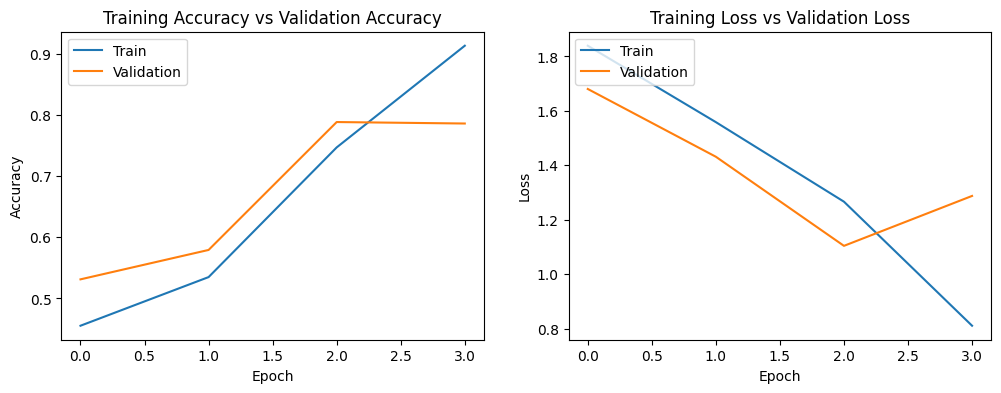

In [12]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(12,4)


ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

### predicting on Testing data

In [13]:
testing_seq = token.texts_to_sequences(X_test)
test_padded = pad_sequences(testing_seq, maxlen=max_length)


In [14]:
scores = model.evaluate(test_padded, y_test)
print("Loss ", scores[0])
print("Accuracy ", scores[1])
print("F1 ", scores[2])
print("Recall ", scores[3])
print("Precision ", scores[4])

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.7924 - f1_score: 0.8251 - loss: 1.2506 - precision: 0.7231 - recall: 0.9609
Loss  1.2587403059005737
Accuracy  0.7918170690536499
F1  0.8188481330871582
Recall  0.9583333134651184
Precision  0.7148080468177795


### Evaluation 

Overfitting is taking place on the model. This is more likely because of the lack of fake news data or false labels within the dataset.  
i will have to do text augemantation to create more false labels and check if anything changes.